Bayesian Neural Network model traning and prediction data generation.

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import pickle

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tf.keras.backend.set_floatx("float32")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from scipy.stats import norm

Load the training databases, generated in player_match_database_creation

In [3]:
db1 = pd.read_excel('mid_outputs/database_entries.xlsx', index_col = 0)   
db2 = pd.read_excel('mid_outputs/season2021/database_entries.xlsx', index_col = 0)   
db3 = pd.read_excel('mid_outputs/season2122/database_entries.xlsx', index_col = 0)   

In [4]:
db = pd.concat([db1, db2, db3], ignore_index = True) 

db

,matchday,player,team,oppteam,home,vote,goals,assists,cards_malus,fantavote,...,touches_live_ball,dribbles_completed,dribbles,passes_received,miscontrols,dispossessed,fouls,fouled,aerials_won,aerials_lost
0,1,Toloi,Atalanta,Sampdoria,0,7.0,1,0,0.0,10.0,...,0.617096,0.001171,0.004684,0.357143,0.007026,0.001171,0.009368,0.005855,0.018735,0.008197
1,1,Djimsiti,Atalanta,Sampdoria,0,6.0,0,0,0.0,6.0,...,0.736842,0.000000,0.002924,0.511696,0.002924,0.008772,0.002924,0.002924,0.005848,0.008772
2,1,Hateboer,Atalanta,Sampdoria,0,6.0,0,0,0.5,5.5,...,0.574423,0.002096,0.005241,0.339623,0.006289,0.005241,0.013627,0.002096,0.015723,0.012579
3,1,Okoli,Atalanta,Sampdoria,0,5.5,0,0,0.5,5.0,...,0.598540,0.000000,0.001217,0.278589,0.013382,0.003650,0.015815,0.008516,0.048662,0.026764
4,1,Zortea,Atalanta,Sampdoria,0,6.0,0,0,0.5,5.5,...,0.634921,0.052910,0.111111,0.328042,0.026455,0.005291,0.021164,0.000000,0.026455,0.005291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22942,38,Tameze,Verona,Lazio,0,5.5,0,0,0.0,5.5,...,0.629371,0.013209,0.023310,0.358197,0.019814,0.010101,0.012821,0.013209,0.023699,0.021368
22943,38,Hongla,Verona,Lazio,0,7.0,1,0,0.5,9.5,...,0.582181,0.001536,0.007680,0.341014,0.018433,0.012289,0.023041,0.007680,0.023041,0.026114
22944,38,Lasagna,Verona,Lazio,0,7.0,1,0,0.5,9.5,...,0.369932,0.008446,0.016047,0.262669,0.046453,0.022804,0.016047,0.008446,0.026182,0.041385
22945,38,Caprari,Verona,Lazio,0,6.0,0,0,0.0,6.0,...,0.602410,0.023731,0.043447,0.453815,0.033954,0.019715,0.015334,0.027017,0.002921,0.009858


In [5]:
db_gk1 = pd.read_excel('mid_outputs/database_entries_gk.xlsx', index_col = 0)   
db_gk2 = pd.read_excel('mid_outputs/season2021/database_entries_gk.xlsx', index_col = 0)   
db_gk3 = pd.read_excel('mid_outputs/season2122/database_entries_gk.xlsx', index_col = 0)   

db_gk = pd.concat([db_gk1, db_gk1, db_gk1], ignore_index = True) 

db_gk

,matchday,player,team,oppteam,home,vote,goals,assists,cards_malus,fantavote,...,gk_psxg,gk_psnpxg_per_shot_on_target_against,gk_psxg_net,gk_passes_completed_launched,gk_passes_launched,gk_passes,gk_passes_throws,gk_goal_kicks,gk_crosses,gk_crosses_stopped
0,1,Musso,Atalanta,Sampdoria,0,6.0,0,0,0.5,5.5,...,5.900000,0.220000,0.90,59.0,126.000000,222.000000,62.000000,55.000000,98.0,3.000000
1,1,Skorupski,Bologna,Lazio,0,6.5,-2,0,0.0,4.5,...,21.000000,0.270000,-2.00,62.0,162.000000,408.000000,81.000000,104.000000,203.0,10.000000
2,1,Radu I.,Cremonese,Fiorentina,0,5.0,-3,0,0.0,2.0,...,21.000000,0.290000,2.00,38.0,143.000000,265.000000,34.000000,67.000000,107.0,6.000000
3,1,Vicario,Empoli,Spezia,0,5.5,-1,0,0.0,4.5,...,20.400000,0.300000,1.40,68.0,213.000000,505.000000,85.000000,76.000000,285.0,20.000000
4,1,Gollini,Fiorentina,Cremonese,1,5.0,-2,0,0.0,3.0,...,7.650000,0.270000,-1.35,28.0,79.500000,207.000000,28.500000,40.000000,64.0,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,14,Consigli,Sassuolo,Roma,1,6.5,-1,0,0.0,5.5,...,16.600000,0.370000,-2.40,84.0,205.000000,523.000000,77.000000,134.000000,189.0,13.000000
842,14,Zoet,Spezia,Udinese,1,6.0,-1,0,0.0,5.0,...,17.616667,0.246667,-2.55,51.5,160.833333,305.666667,58.833333,68.666667,150.5,6.666667
843,14,Milinkovic-Savic V.,Torino,Sampdoria,1,6.0,0,0,0.0,6.0,...,16.800000,0.270000,0.80,97.0,335.000000,507.000000,55.000000,102.000000,160.0,11.000000
844,14,Silvestri,Udinese,Spezia,0,7.0,-1,0,0.0,6.0,...,16.000000,0.280000,2.00,59.0,148.000000,287.000000,57.000000,110.000000,194.0,4.000000


Load player stats from current season and past seasons

In [6]:
players_orig = pd.read_excel('mid_outputs/players_stats.xlsx', index_col = 3)
#players = pd.read_excel('mid_outputs/players_stats_rwk.xlsx', index_col = 3) # reworked stats to account for past season

players_old = pd.read_excel('mid_outputs/season2122/players_stats.xlsx', index_col = 3)
players_old_2 = pd.read_excel('mid_outputs/season2021/players_stats.xlsx', index_col = 3)

players = players_orig

Load team data from current season and add an average Serie A team row

In [7]:
team_data = pd.read_excel('mid_outputs/team_data.xlsx', index_col = 0)

avg_row = pd.DataFrame(index = ['Avg'], data = [team_data.mean()], columns = team_data.columns)
avg_row['team']['Avg'] = 'Avg'

team_data = pd.concat([team_data, avg_row])

team_data

C:\Users\nicol\AppData\Local\Temp\ipykernel_17524\661405348.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_row = pd.DataFrame(index = ['Avg'], data = [team_data.mean()], columns = team_data.columns)


,team,team_players_used,team_possession,team_games,team_games_starts,team_minutes,team_goals,team_assists,team_pens_made,team_pens_att,...,vs_team_fouls,vs_team_fouled,vs_team_offsides,vs_team_pens_won,vs_team_pens_conceded,vs_team_own_goals,vs_team_ball_recoveries,vs_team_aerials_won,vs_team_aerials_lost,vs_team_aerials_won_pct
Atalanta,Atalanta,23.0,46.400,14.0,154.0,1260.0,19.0,14.0,4.0,5.0,...,150.0,168.00,19.00,0.0,5.0,1.0,834.0,181.0,211.0,46.200
Bologna,Bologna,23.0,51.100,14.0,154.0,1260.0,17.0,12.0,3.0,3.0,...,182.0,158.00,24.00,2.0,3.0,0.0,731.0,165.0,123.0,57.300
Cremonese,Cremonese,27.0,43.200,14.0,154.0,1260.0,11.0,5.0,1.0,3.0,...,145.0,188.00,19.00,2.0,3.0,0.0,744.0,242.0,184.0,56.800
Empoli,Empoli,25.0,46.000,14.0,154.0,1260.0,10.0,5.0,0.0,0.0,...,176.0,151.00,28.00,2.0,0.0,0.0,723.0,163.0,135.0,54.700
Fiorentina,Fiorentina,25.0,58.700,14.0,154.0,1260.0,17.0,15.0,1.0,3.0,...,186.0,176.00,35.00,1.0,3.0,0.0,694.0,193.0,224.0,46.300
Verona,Hellas Verona,29.0,43.900,14.0,154.0,1260.0,10.0,7.0,0.0,0.0,...,130.0,205.00,18.00,1.0,0.0,1.0,758.0,240.0,229.0,51.200
Inter,Inter,23.0,54.600,14.0,154.0,1260.0,31.0,22.0,2.0,2.0,...,182.0,154.00,14.00,1.0,2.0,0.0,596.0,126.0,172.0,42.300
Juventus,Juventus,26.0,50.500,14.0,154.0,1260.0,21.0,17.0,1.0,2.0,...,161.0,156.00,21.00,0.0,2.0,0.0,674.0,184.0,166.0,52.600
Lazio,Lazio,21.0,50.000,14.0,154.0,1260.0,25.0,20.0,1.0,2.0,...,197.0,124.00,35.00,1.0,2.0,1.0,746.0,151.0,126.0,54.500
Lecce,Lecce,24.0,40.700,14.0,154.0,1260.0,12.0,8.0,1.0,2.0,...,184.0,184.00,27.00,3.0,2.0,0.0,703.0,216.0,188.0,53.500


Data processing functions copied from player_match_dataset_creation

In [8]:
features_abs = ['r',
 'games',
 'games_starts',                
 'minutes',
 'shots_on_target_pct',
 'goals_per_shot',
 'goals_per_shot_on_target',
 'passes_pct',
 'dribble_tackles_pct',
 'dribbles_completed_pct',
 'aerials_won_pct',
 'team_possession',
 'team_goals_assists_per90',
 'team_goals_pens_per90',
 'team_goals_assists_pens_per90',
 'team_xg_per90',
 'team_gk_goals_against_per90',
 'team_gk_save_pct',
 'team_gk_clean_sheets_pct',
 'team_passes_pct',
 'team_passes_pct_medium',
 'team_passes_pct_long',
 'team_sca_per90',
 'team_gca_per90',
 'team_dribble_tackles_pct',
 'team_aerials_won_pct',
 'vs_team_possession',
 'vs_team_goals_per90',
 'vs_team_assists_per90',
 'vs_team_xg_per90',
 'vs_team_gk_save_pct',
 'vs_team_gk_clean_sheets_pct',
 'vs_team_gk_pct_passes_launched',
 'vs_team_gk_crosses_stopped_pct',
 'vs_team_shots_on_target_per90',
 'vs_team_passes_pct',
 'vs_team_passes_pct_short',
 'vs_team_passes_pct_medium',
 'vs_team_passes_pct_long',
 'vs_team_sca_per90',
 'vs_team_gca_per90',
 'vs_team_dribble_tackles_pct',
 'vs_team_dribbles_completed_pct',
 'vs_team_aerials_won_pct',
 'opp_team_possession',
 'opp_team_goals_assists_per90',
 'opp_team_goals_pens_per90',
 'opp_team_goals_assists_pens_per90',
 'opp_team_xg_per90',
 'opp_team_gk_goals_against_per90',
 'opp_team_gk_save_pct',
 'opp_team_gk_clean_sheets_pct',
 'opp_team_passes_pct',
 'opp_team_passes_pct_medium',
 'opp_team_passes_pct_long',
 'opp_team_sca_per90',
 'opp_team_gca_per90',
 'opp_team_dribble_tackles_pct',
 'opp_team_aerials_won_pct',
 'opp_vs_team_possession',
 'opp_vs_team_goals_per90',
 'opp_vs_team_assists_per90',
 'opp_vs_team_xg_per90',
 'opp_vs_team_gk_save_pct',
 'opp_vs_team_gk_clean_sheets_pct',
 'opp_vs_team_gk_pct_passes_launched',
 'opp_vs_team_gk_crosses_stopped_pct',
 'opp_vs_team_shots_on_target_per90',
 'opp_vs_team_passes_pct',
 'opp_vs_team_passes_pct_short',
 'opp_vs_team_passes_pct_medium',
 'opp_vs_team_passes_pct_long',
 'opp_vs_team_sca_per90',
 'opp_vs_team_gca_per90',
 'opp_vs_team_dribble_tackles_pct',
 'opp_vs_team_dribbles_completed_pct',
 'opp_vs_team_aerials_won_pct',
                
 'vote_avg',
 'vote_std']

features_rel = [
 'goals',
 'assists',
 'cards_yellow',
 'cards_red',
 'xg',
 'npxg',
 'shots_on_target',
 'passes_completed',
 'passes_into_final_third',
 'passes_into_penalty_area',
 'progressive_passes',
 'passes_live',
 'passes_dead',
 'through_balls',
 'passes_switches',
 'crosses',
 'corner_kicks',
 'dribble_tackles',
 'dribbles_vs',
 'dribbled_past',
 'blocks',
 'blocked_shots',
 'blocked_passes',
 'interceptions',
 'clearances',
 'errors',
 'touches',
 'touches_def_pen_area',
 'touches_def_3rd',
 'touches_mid_3rd',
 'touches_att_3rd',
 'touches_att_pen_area',
 'touches_live_ball',
 'dribbles_completed',
 'dribbles',
 'passes_received',
 'miscontrols',
 'dispossessed',
 'fouls',
 'fouled',
 'aerials_won',
 'aerials_lost']

features_rel_gamecorr = [
    'goals',
    'xg',
    'npxg',
    'assists',
    'cards_yellow',
    'cards_red'
]

DEL_G = False

features_to_del = [
    'goals',
    'assists',
    'xg',
    'npxg'
]

def player_match_data(player, pteam, oppteam, oldseason = False):
    if(not(player in players.index)):
        return None
    
    if(oldseason):
        pdata = players_old.loc[[player]]
    else:
        pdata = players.loc[[player]]
    
    pteam_stats = team_data.loc[[pteam]].rename(index = {pteam : player})
    
    oppteam_stats = team_data.loc[[oppteam]].rename(index = {oppteam : player})
    
    oppteam_stats = oppteam_stats.rename(lambda x: 'opp_' + x, axis='columns')
    
    out = pd.concat([pdata, pteam_stats, oppteam_stats], axis = 1)
    
    return(out)

def player_match_data_ext(player, pteam, oppteam, oldseason = False):
    pdata = player_match_data(player, pteam, oppteam, oldseason = oldseason)
    
    if(not isinstance(pdata, pd.DataFrame)):
        return None
    
    assert pdata['games'][0] > 0
        
    out = pd.concat([pdata[features_abs], pdata[features_rel]], axis = 1)
    
    out[features_rel] = out[features_rel] / max(pdata['minutes'][0], 1)
    
    out[features_rel_gamecorr] = out[features_rel_gamecorr] * (pdata['minutes'][0] / max(pdata['games'][0], 1) / 90)
    
    if(DEL_G):
        out[features_to_del] = 0
    
    return out




features_abs_gk = [
 'gk_games',
 'gk_games_starts',
 'gk_minutes',
 'gk_goals_against_per90', 
 'gk_save_pct',
 'gk_clean_sheets_pct',
 'gk_psxg_net_per90',
 'gk_passes_pct_launched',
 'gk_pct_passes_launched',
 'gk_passes_length_avg',
 'gk_pct_goal_kicks_launched',
 'gk_goal_kick_length_avg',
 'gk_crosses_stopped_pct',
 'gk_def_actions_outside_pen_area_per90',
 'gk_avg_distance_def_actions',
    
 'team_possession',
 'team_goals_assists_per90',
 'team_goals_pens_per90',
 'team_goals_assists_pens_per90',
 'team_xg_per90',
 'team_gk_goals_against_per90',
 'team_gk_save_pct',
 'team_gk_clean_sheets_pct',
 'team_passes_pct',
 'team_passes_pct_medium',
 'team_passes_pct_long',
 'team_sca_per90',
 'team_gca_per90',
 'team_dribble_tackles_pct',
 'team_aerials_won_pct',
 'vs_team_possession',
 'vs_team_goals_per90',
 'vs_team_assists_per90',
 'vs_team_xg_per90',
 'vs_team_gk_save_pct',
 'vs_team_gk_clean_sheets_pct',
 'vs_team_gk_pct_passes_launched',
 'vs_team_gk_crosses_stopped_pct',
 'vs_team_shots_on_target_per90',
 'vs_team_passes_pct',
 'vs_team_passes_pct_short',
 'vs_team_passes_pct_medium',
 'vs_team_passes_pct_long',
 'vs_team_sca_per90',
 'vs_team_gca_per90',
 'vs_team_dribble_tackles_pct',
 'vs_team_dribbles_completed_pct',
 'vs_team_aerials_won_pct',
 'opp_team_possession',
 'opp_team_goals_assists_per90',
 'opp_team_goals_pens_per90',
 'opp_team_goals_assists_pens_per90',
 'opp_team_xg_per90',
 'opp_team_gk_goals_against_per90',
 'opp_team_gk_save_pct',
 'opp_team_gk_clean_sheets_pct',
 'opp_team_passes_pct',
 'opp_team_passes_pct_medium',
 'opp_team_passes_pct_long',
 'opp_team_sca_per90',
 'opp_team_gca_per90',
 'opp_team_dribble_tackles_pct',
 'opp_team_aerials_won_pct',
 'opp_vs_team_possession',
 'opp_vs_team_goals_per90',
 'opp_vs_team_assists_per90',
 'opp_vs_team_xg_per90',
 'opp_vs_team_gk_save_pct',
 'opp_vs_team_gk_clean_sheets_pct',
 'opp_vs_team_gk_pct_passes_launched',
 'opp_vs_team_gk_crosses_stopped_pct',
 'opp_vs_team_shots_on_target_per90',
 'opp_vs_team_passes_pct',
 'opp_vs_team_passes_pct_short',
 'opp_vs_team_passes_pct_medium',
 'opp_vs_team_passes_pct_long',
 'opp_vs_team_sca_per90',
 'opp_vs_team_gca_per90',
 'opp_vs_team_dribble_tackles_pct',
 'opp_vs_team_dribbles_completed_pct',
 'opp_vs_team_aerials_won_pct',
                
 'vote_avg',
 'vote_std']

features_rel_gk = [
 'gk_shots_on_target_against',
 'gk_saves',
 'gk_free_kick_goals_against',
 'gk_corner_kick_goals_against',
 'gk_own_goals_against',
 'gk_psxg',
 'gk_psnpxg_per_shot_on_target_against',
 'gk_psxg_net',
 'gk_passes_completed_launched',
 'gk_passes_launched',
 'gk_passes',
 'gk_passes_throws',
 'gk_goal_kicks',
 'gk_crosses',
 'gk_crosses_stopped',
]

def player_match_data_ext_gk(player, pteam, oppteam, oldseason = False):
    pdata = player_match_data(player, pteam, oppteam, oldseason = oldseason)
    
    if(not isinstance(pdata, pd.DataFrame)):
        return None
    
    if(pdata['gk_games'][0] <= 0):
        return None
    
    out = pd.concat([pdata[features_abs_gk], pdata[features_rel_gk]], axis = 1)
    
    out[features_rel_gk] = out[features_rel_gk] / max(pdata['minutes'][0], 1)

    return out
    

Players stats rework:
the current season stats are averaged (according to a calculated weight) with the past season data.
In case a player doesn't have past season data, a config file (affine_players) can be used to load the data from an affine player (past season), e.g. Doig affine to Lazovic.
In case, after this process, the player doesn't result in having a minimum amount of games, its stats are averaged with the average Serie A (defensive) player stat, depending on the games remaining to reach the minimum amount. This allows to use players who still haven't played a single game.

These modified stats are used only for prediction, not for model traning.

WEIGHT_0 = weight given to the current season in respect to the previous; if the player has a low amount of games this season, the weight is lowered
min_games = minimum games so that the players stats are not averaged with the avg Serie A player stats

In [9]:
#for i in range(players.columns.shape[0]):
#    print(str(i) + ' - ' + players.columns[i])

cols_toadapt = players.columns[9:]

players = players_orig.copy()

min_games = 6

current_season_games = max(players_orig['games'])

# weight_0 as function of current_season_games --> 1 as match day reachs 30 ? 
WEIGHT_0_same_team = (1 - (1 - 0.7) * (30 - current_season_games) / (38 - 12)) # 0.7
WEIGHT_0_different_team = (1 - (1 - 0.75) * (30 - current_season_games) / (38 - 12)) # 0.75
WEIGHT_mul_gk = 2

rcsv = pd.read_csv('config/affine_players.txt')   
affine_players = pd.DataFrame(rcsv)
affine_players = affine_players.set_index('player')


def calc_weight(games_curr, games_old, same_team = 1, maxgames = current_season_games):
    if(same_team):
        weight_0 = WEIGHT_0_same_team
    else:
        weight_0 = WEIGHT_0_different_team

    weight = weight_0 * (games_curr / maxgames) / (max(games_old, 1) / 38)
    weight = min(weight, 1)

    return abs(weight)

print(' ')
print('Averaging players stats with past seasons:')

for i in range(players.shape[0]):
    p = players.index[i]
    

    if(p in players_old.index or p in affine_players.index):
        p_ = p
        affine = 0
        
        if(p in affine_players.index):
            affine = 1
            p_ = affine_players.loc[p]['alike']
            
            print(p + ' affine to ' + p_)
        
        if(players.loc[p]['r'] == 'P'):
            weight = calc_weight(players.loc[p]['gk_games'], players_old.loc[p_]['gk_games'], affine == 1 or players.loc[p]['team'] == players_old.loc[p]['team'])
            weight *= WEIGHT_mul_gk
            weight = min(weight, 1)
        else:
            weight = calc_weight(players.loc[p]['games'], players_old.loc[p_]['games'], affine == 1 or players.loc[p]['team'] == players_old.loc[p]['team'])

        players.at[p, cols_toadapt] = (players.loc[p][cols_toadapt] * weight + (1-weight) * players_old.loc[p_][cols_toadapt])
        
        print(p + ' ' + str(weight))     
    
    # to handle players like Lukaku, who only played 2 seasons ago; only outfield players
    if(players.loc[p]['r'] != 'P' and players.loc[p]['games'] < min_games and p in players_old_2.index):    
        weight = calc_weight(players.loc[p]['games'], players_old_2.loc[p]['games'], players.loc[p]['team'] == players_old_2.loc[p]['team'])
        
        players.at[p, cols_toadapt] = (players.loc[p][cols_toadapt] * weight + (1-weight) * players_old_2.loc[p][cols_toadapt])
        
        print(p + ' ' + str(weight))
    
    
# handle players with low quantitites of games

print('Players with low quantity of games:')

def calc_weight_low(current_games, min_games = min_games):
    weight = 1 - (min_games - current_games)/min_games
    
    weight = min(weight, 1)

    return abs(weight)

#mean_players_stats = players_orig[players_orig['games'] >= min_games][cols_toadapt].mean()

mean_players_stats = players_orig.loc[players_orig.index[0]][cols_toadapt] * 0
count = 0

for i in range(players_orig.shape[0]):
    if(players_orig['games'][i] >= min_games and (players_orig['r'][i] == 'D')): # counting only defenders, to add a penalty
        mean_players_stats += players_orig.loc[players_orig.index[i]][cols_toadapt]
        count = count + 1
        
mean_players_stats /= count

for i in range(players.shape[0]):
    p = players.index[i]
    
    if(players.loc[p]['games'] < min_games and players.loc[p]['r'] != 'P'):
        weight = calc_weight_low(players.loc[p]['games'])
        
        players.at[p, cols_toadapt] = players.loc[p][cols_toadapt] * weight + (1-weight) * mean_players_stats
        
        print(p + ' ' + str(weight))
        
        
players_out = players.copy()
players_out = players_out.set_index(players_out.columns[0])
players_out.insert(2, 'name', players_out.index)
players_out.to_excel('mid_outputs/players_stats_rwk.xlsx')


 
Averaging players stats with past seasons:
Meret 1
Provedel 1
Maignan 0.9682692307692308
Silvestri 1
Sepe 1
Szczesny 1
Consigli 1
Falcone 1
Musso 1
Vicario 1
Rui Patricio 1
Milinkovic-Savic V. 1
Audero 1
Montipo' 1
Sportiello 1
Skorupski 1
Perin 1
Handanovic 0.957053757053757
Tatarusanu 1
Dragowski 1
Terracciano 1
Berisha 1
Radu I. 1
Cragno 1
Mirante 0.9682692307692308
Ujkani 1
Pegolo 1
Padelli 1
Bardi 1
Cordaz 0.957053757053757
Pinsoglio 1
Fiorillo 1
Sirigu 1
Rossi F. 1
Berardi A. 1
Gemello 1
Ravaglia 1
Zoet 1
Boer 1
Adamonis 1
Marfella 1
Zovko 1
Piana 1
Smalling 1
Hernandez T. 0.829945054945055
Bastoni S. 0.7139312300602624
Udogie 0.6955729984301412
Dumfries 0.9389277389277388
Romagnoli 1
Rodrigo Becao 0.569105180533752
Parisi 1
Mazzocchi 1
Bremer 0.8351648351648351
Demiral 0.94850863422292
Dimarco 0.9682692307692308
Di Lorenzo 0.9389277389277388
Ibanez 0.9113122171945701
Tomori 0.9995037220843672
Toloi 1
Gosens 1
Rrahmani 0.5365301365301365
Kalulu 1
Bijol affine to Rodrigo Becao
B

Dermaku 0.16666666666666663
Paletta 0.0
Romagna 0.0
Cetin 0.681013431013431
Adopo 0.5
Antov 0.6666666666666667
Amey 0.16666666666666663
Ferrarini 0.0
Kamenovic 0.16666666666666663
Zanotti 0.0
Motoc 0.0
Bayeye 0.0
Ebosele 0.33333333333333337
Buta 0.0
Ndiaye 0.0
Abankwah 0.0
Guessand A. 0.0
Guarino 0.0
Pogba 0.0
Wijnaldum 0.16666666666666663
Vranckx 0.5
Winks 0.0
Maldini 0.8333333333333334
Moro N. 0.6666666666666667
Valoti 0.8333333333333334
Gaetano 0.5
Bohinen 0.8333333333333334
Milanese 0.16666666666666663
Listkowski 0.8333333333333334
Adli 0.6666666666666667
Hrustic 0.8333333333333334
D'andrea 0.8333333333333334
Baez 0.33333333333333337
Yepes 0.6666666666666667
Bondo 0.6666666666666667
Capezzi 0.8333333333333334
Machin 0.0
Scozzarella 0.0
Akpa Akpro 0.0
Darboe 0.5382417582417582
Bove 0.8333333333333334
Urbanski 0.16666666666666663
Bertini 0.0
Cortinovis 0.16666666666666663
Romero L. 0.78003663003663
Bianco 0.0
Sher 0.16666666666666663
Nguiamba 0.5
Volpato 0.5
Praszelik 0.3333333333333

In [10]:
players.columns[9:]

Index(['games', 'games_starts', 'minutes', 'goals', 'assists', 'pens_made',
       'pens_att', 'cards_yellow', 'cards_red', 'goals_per90',
       ...
       'gk_pct_goal_kicks_launched', 'gk_goal_kick_length_avg', 'gk_crosses',
       'gk_crosses_stopped', 'gk_crosses_stopped_pct',
       'gk_def_actions_outside_pen_area',
       'gk_def_actions_outside_pen_area_per90', 'gk_avg_distance_def_actions',
       'vote_avg', 'vote_std'],
      dtype='object', length=156)

In [11]:
for i in range(db.columns.shape[0]):
    print(str(i) + " - " + str(db.columns[i]))

0 - matchday
1 - player
2 - team
3 - oppteam
4 - home
5 - vote
6 - goals
7 - assists
8 - cards_malus
9 - fantavote
10 - r
11 - games
12 - games_starts
13 - minutes
14 - shots_on_target_pct
15 - goals_per_shot
16 - goals_per_shot_on_target
17 - passes_pct
18 - dribble_tackles_pct
19 - dribbles_completed_pct
20 - aerials_won_pct
21 - team_possession
22 - team_goals_assists_per90
23 - team_goals_pens_per90
24 - team_goals_assists_pens_per90
25 - team_xg_per90
26 - team_gk_goals_against_per90
27 - team_gk_save_pct
28 - team_gk_clean_sheets_pct
29 - team_passes_pct
30 - team_passes_pct_medium
31 - team_passes_pct_long
32 - team_sca_per90
33 - team_gca_per90
34 - team_dribble_tackles_pct
35 - team_aerials_won_pct
36 - vs_team_possession
37 - vs_team_goals_per90
38 - vs_team_assists_per90
39 - vs_team_xg_per90
40 - vs_team_gk_save_pct
41 - vs_team_gk_clean_sheets_pct
42 - vs_team_gk_pct_passes_launched
43 - vs_team_gk_crosses_stopped_pct
44 - vs_team_shots_on_target_per90
45 - vs_team_passes_

Elaborate databases data to have X and y for training, and split into a train test and a validation test.

For outfield players: X -> y = [vote, fantavote]

For goalkeepers: X -> y = [vote, fantavote, clean sheet probability]

In [12]:
npdb = np.array(db)

y = npdb[:, [5,9]] # vote, fantavote

#y[:, 1] = y[:, 1] - y[:, 0] # target = difference between fantavote and vote

f_start = 14

X = npdb[:, f_start:]

if(DEL_G): 
    del_g_idx = [
        list(db.columns).index('goals.1') - f_start,
        list(db.columns).index('assists.1') - f_start,
        list(db.columns).index('xg') - f_start,
        list(db.columns).index('npxg') - f_start,
        list(db.columns).index('shots_on_target') - f_start]
    
    X[:, del_g_idx] = 0


# add role and home factor
toadd = np.zeros((X.shape[0], 4))
toadd[:, 0] = npdb[:, 4] # home

toadd[:, 1] = npdb[:, 10] == 'D'
toadd[:, 2] = npdb[:, 10] == 'C'
toadd[:, 3] = npdb[:, 10] == 'A'

X = np.concatenate((X, toadd), axis = 1)



In [13]:
scaler = StandardScaler()
scaler.fit(X)

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

X_train = scaler.transform(X_train_)
X_test = scaler.transform(X_test_)

In [14]:
for i in range(db_gk.columns.shape[0]):
    print(str(i) + " - " + str(db_gk.columns[i]))

0 - matchday
1 - player
2 - team
3 - oppteam
4 - home
5 - vote
6 - goals
7 - assists
8 - cards_malus
9 - fantavote
10 - gk_games
11 - gk_games_starts
12 - gk_minutes
13 - gk_goals_against_per90
14 - gk_save_pct
15 - gk_clean_sheets_pct
16 - gk_psxg_net_per90
17 - gk_passes_pct_launched
18 - gk_pct_passes_launched
19 - gk_passes_length_avg
20 - gk_pct_goal_kicks_launched
21 - gk_goal_kick_length_avg
22 - gk_crosses_stopped_pct
23 - gk_def_actions_outside_pen_area_per90
24 - gk_avg_distance_def_actions
25 - team_possession
26 - team_goals_assists_per90
27 - team_goals_pens_per90
28 - team_goals_assists_pens_per90
29 - team_xg_per90
30 - team_gk_goals_against_per90
31 - team_gk_save_pct
32 - team_gk_clean_sheets_pct
33 - team_passes_pct
34 - team_passes_pct_medium
35 - team_passes_pct_long
36 - team_sca_per90
37 - team_gca_per90
38 - team_dribble_tackles_pct
39 - team_aerials_won_pct
40 - vs_team_possession
41 - vs_team_goals_per90
42 - vs_team_assists_per90
43 - vs_team_xg_per90
44 - vs_

In [15]:
npdb_gk= np.array(db_gk)

y_gk = npdb_gk[:, [5,9,6]] # vote, fantavote, goals == 0 (clean sheet)
y_gk[:, 2] = (y_gk[:, 2] == 0) * 1

f_start_gk = 13

X_gk = npdb_gk[:, f_start_gk:]

# add home factor
toadd_gk = np.zeros((X_gk.shape[0], 1))
toadd_gk[:, 0] = npdb_gk[:, 4] # home

X_gk = np.concatenate((X_gk, toadd_gk), axis = 1)



In [16]:
scaler_gk = StandardScaler()
scaler_gk.fit(X_gk)

X_gk_train_, X_gk_test_, y_gk_train, y_gk_test = train_test_split(X_gk, y_gk, test_size = 0.2, random_state = 18)

X_gk_train = scaler_gk.transform(X_gk_train_)
X_gk_test = scaler_gk.transform(X_gk_test_)

MLP Regressor , to see performance of a simple neural network

0.1569906306642661
0.19152381866355805


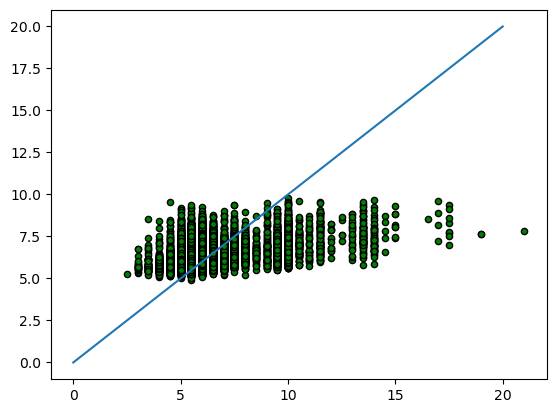

0.1532751047011487
0.17630547391900842


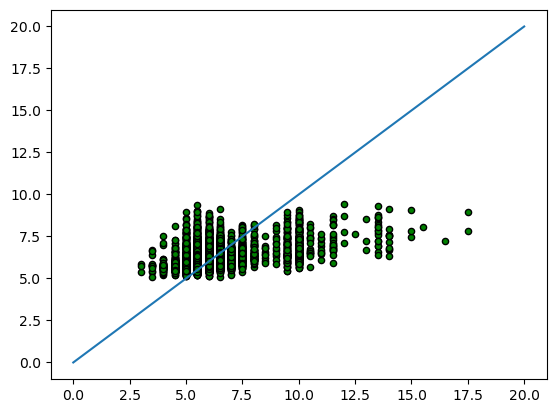

In [17]:
regr = MLPRegressor(max_iter = 400000, solver = 'lbfgs', hidden_layer_sizes = (8, 8), alpha = 500, verbose = True)

regr.fit(X_train, y_train)


y_train_predict = regr.predict(X_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_train[:, 0], y_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_train[:, 1], y_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_train[:, 0], y_train_predict[:, 0]))
print(r2_score(y_train[:, 1], y_train_predict[:, 1]))


plt.show()

y_test_predict = regr.predict(X_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_test[:, 0], y_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_test[:, 1], y_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_test[:, 0], y_test_predict[:, 0]))
print(r2_score(y_test[:, 1], y_test_predict[:, 1]))


plt.show()

Train neural network for outfield players.

The outputs of the NN are probability distribution of SinhArcsinh type (a skewed distribution, which is a generalization of Gaussian)

In [17]:
load_model_of = True# load scaler and model weights for outfield player predictor
refit_model_of = False

if(load_model_of):
    scaler = pickle.load(open('saves/scaler.pkl', 'rb'))
    
    X_train = scaler.transform(X_train_)
    X_test = scaler.transform(X_test_)


n_epochs = 1000

n_samples = X_train.shape[0]

batch_size = 256

X_len = X_train.shape[1]
y_len = y_train.shape[1]


#tailweight_param = 1.1

tailweight_min = 0.5
tailweight_range = 1.2


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)


inputs = tfk.layers.Input(shape=(X_len,), name="input")
x = tfk.layers.Dropout(0.2)(inputs)
x = tfk.layers.Dense(16, activation="relu") (x)
x = tfk.layers.Dropout(0.2)(x)
x = tfk.layers.Dense(16, activation="relu") (x)


prob_dist_params = 4

def prob_dist(t): 
    return tfp.distributions.SinhArcsinh(loc=t[..., 0], scale=1e-3 + tf.math.softplus(t[..., 1]), skewness = t[..., 2], 
                                        tailweight = tailweight_min + tailweight_range * tf.math.sigmoid(t[..., 3]),
                                        allow_nan_stats = False)

x1 = tfk.layers.Dense(8, activation="sigmoid")(x)
x1 = tfk.layers.Dense(prob_dist_params, activation="linear")(x1)
out_1 = tfp.layers.DistributionLambda(prob_dist)(x1)

x2 = tfk.layers.Dense(8, activation="sigmoid")(x)
x2 = tfk.layers.Dense(prob_dist_params, activation="linear")(x2)
out_2 = tfp.layers.DistributionLambda(prob_dist)(x2)


modelb = tf.keras.Model(inputs, [out_1, out_2])

modelb.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.001), 
              loss=neg_log_likelihood)

if(load_model_of):
    modelb.load_weights('saves/modelb')
    
if( (not load_model_of) or refit_model_of):
    modelb.fit(X_train.astype('float32'), [y_train[:, 0].astype('float32'), y_train[:, 1].astype('float32')], 
              validation_data = (X_test.astype('float32'), [y_test[:, 0].astype('float32'), y_test[:, 1].astype('float32')]),
              batch_size = batch_size, shuffle = True, epochs=n_epochs, verbose=True, callbacks = [callback])

In [18]:
def sample_predict(X, iterations = 100):
    y = np.zeros((2, X.shape[0]))
    
    dist = modelb(X)
    
    for i in range(iterations):
        y[0, :] += dist[0].sample()
        y[1, :] += dist[1].sample()
        
    return y.transpose() / iterations
    

0.1422293477741312
0.16931391630989778


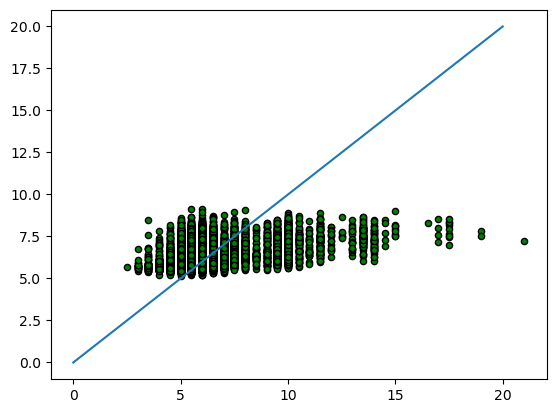

0.1431761226649988
0.16687106328443524


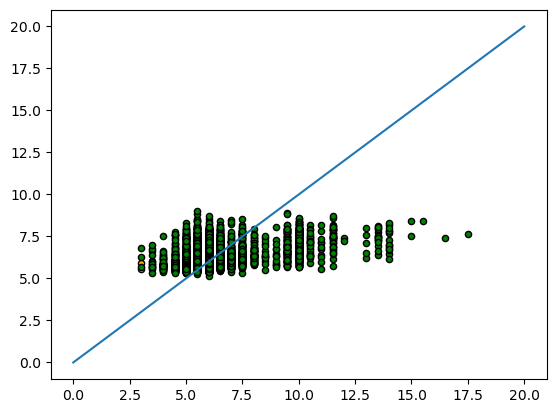

In [19]:
y_train_predict = sample_predict(X_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_train[:, 0], y_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_train[:, 1], y_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_train[:, 0], y_train_predict[:, 0]))
print(r2_score(y_train[:, 1], y_train_predict[:, 1]))

plt.show()

y_test_predict = sample_predict(X_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_test[:, 0], y_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_test[:, 1], y_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_test[:, 0], y_test_predict[:, 0]))
print(r2_score(y_test[:, 1], y_test_predict[:, 1]))




Train neural network for goalkeepers.

For clean sheet probability prediction, a Bernoulli distribution is used.

In [19]:
load_model_gk = True # load scaler and model weights for goalkeeper player predictor
refit_model_gk = False

if(load_model_gk):
    scaler_gk = pickle.load(open('saves/scaler_gk.pkl', 'rb'))
    
    X_gk_train = scaler_gk.transform(X_gk_train_)
    X_gk_test = scaler_gk.transform(X_gk_test_)
    
    
n_epochs = 2000

n_samples = X_gk_train.shape[0]

batch_size = 128

X_gk_len = X_gk_train.shape[1]
y_gk_len = y_gk_train.shape[1]


#tailweight_param = 1.1

tailweight_min = 0.5
tailweight_range = 1.5


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 30)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)


inputs = tfk.layers.Input(shape=(X_gk_len,), name="input")
x = tfk.layers.Dense(16, activation="sigmoid") (inputs)
x = tfk.layers.Dropout(0.3)(x)
x = tfk.layers.Dense(16, activation="sigmoid") (x)


prob_dist_params = 4

def prob_dist(t): 
    return tfp.distributions.SinhArcsinh(loc=t[..., 0], scale=1e-3 + tf.math.softplus(t[..., 1]), skewness = t[..., 2], 
                                        tailweight = tailweight_min + tailweight_range * tf.math.sigmoid(t[..., 3]),
                                        allow_nan_stats = False)

x1 = tfk.layers.Dense(8, activation="sigmoid")(x)
x1 = tfk.layers.Dense(prob_dist_params, activation="linear")(x1)
out_1 = tfp.layers.DistributionLambda(prob_dist)(x1)

x2 = tfk.layers.Dense(8, activation="sigmoid")(x)

x22 = tfk.layers.Dense(prob_dist_params, activation="linear")(x2)
out_2 = tfp.layers.DistributionLambda(prob_dist)(x22)

x23 = tfk.layers.Dense(1, activation="sigmoid")(x2)
out_3 = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Bernoulli(probs = t[..., 0]))(x23)


modelb_gk = tf.keras.Model(inputs, [out_1, out_2, out_3])

modelb_gk.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.001), 
              loss=neg_log_likelihood)

if(load_model_gk):
    modelb_gk.load_weights('saves/modelb_gk')

if( (not load_model_gk) or refit_model_gk):    
    modelb_gk.fit(X_gk_train.astype('float32'), [y_gk_train[:, 0].astype('float32'), y_gk_train[:, 1].astype('float32'), y_gk_train[:, 2].astype('int')], 
              validation_data = (X_gk_test.astype('float32'), [y_gk_test[:, 0].astype('float32'), y_gk_test[:, 1].astype('float32'), y_gk_test[:, 2].astype('int')]),
              batch_size = batch_size, shuffle = True, epochs=n_epochs, verbose=True, callbacks = [callback])

In [20]:
def sample_predict_gk(X, iterations = 100):
    y = np.zeros((3, X.shape[0]))
    
    dist = modelb_gk(X)
    
    for i in range(iterations):
        y[0, :] += dist[0].sample()
        y[1, :] += dist[1].sample()
        y[2, :] += dist[2].sample()
        
    return y.transpose() / iterations


0.45257318940839
0.5349007718848356


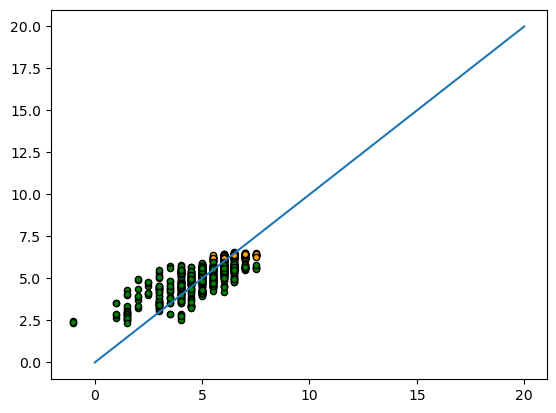

0.37645262592381834
0.43365123619886836


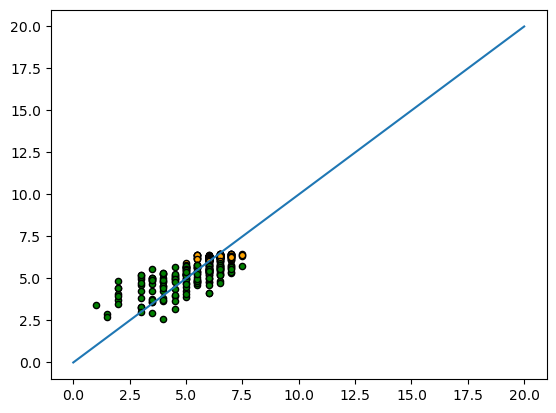

In [22]:
y_gk_train_predict = sample_predict_gk(X_gk_train)

plt.plot([0, 20], [0, 20])

plt.scatter(y_gk_train[:, 0], y_gk_train_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_gk_train[:, 1], y_gk_train_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_gk_train[:, 0], y_gk_train_predict[:, 0]))
print(r2_score(y_gk_train[:, 1], y_gk_train_predict[:, 1]))

plt.show()

y_gk_test_predict = sample_predict_gk(X_gk_test)

plt.plot([0, 20], [0, 20])

plt.scatter(y_gk_test[:, 0], y_gk_test_predict[:, 0], color = 'orange', edgecolors = 'black', s = 20)
plt.scatter(y_gk_test[:, 1], y_gk_test_predict[:, 1], color = 'green', edgecolors = 'black', s = 20)

print(r2_score(y_gk_test[:, 0], y_gk_test_predict[:, 0]))
print(r2_score(y_gk_test[:, 1], y_gk_test_predict[:, 1]))




Use the following codes to save the scalers and the model weights

In [21]:
save_model_of = False
save_model_gk = False

if(save_model_of):
    pickle.dump(scaler, open('saves/scaler.pkl', 'wb'))
    modelb.save_weights('saves/modelb')
    
if(save_model_gk):
    pickle.dump(scaler_gk, open('saves/scaler_gk.pkl', 'wb'))
    modelb_gk.save_weights('saves/modelb_gk')
    

Generalized prediction function for a player (playing for team against opp_team, at home or not)

Estimate prediction mean and sigma (using a custom definitions).

Generate a plot.


In [22]:
def vote_predict_NNb(player, team, opp_team, home = 1, plot = 0, log = 0, oldseason = False):
    if(players['r'][player] == 'P'):
        ptest = player_match_data_ext_gk(player, team, opp_team, oldseason = oldseason)

        x_ptest = np.array(ptest)[:, 3:]
        r = np.array(ptest)[0, 0]

        # add home and role
        xadd = np.zeros((1, 1))
        xadd[0, 0] = home

        x_ptest = np.concatenate((x_ptest, xadd), axis = 1)

        x_scaled = scaler_gk.transform(x_ptest)

        dist = modelb_gk(x_scaled)
        
        clean_shoot_prob = dist[2].probs.numpy()[0]
    else:
        ptest = player_match_data_ext(player, team, opp_team, oldseason = oldseason)

        x_ptest = np.array(ptest)[:, 4:]
        r = np.array(ptest)[0, 0]

        # add home and role
        xadd = np.zeros((1, 4))
        xadd[0, 0] = home
        xadd[0, 1] = r == 'D'
        xadd[0, 2] = r == 'C'
        xadd[0, 3] = r == 'A'

        x_ptest = np.concatenate((x_ptest, xadd), axis = 1)

        x_scaled = scaler.transform(x_ptest)

        dist = modelb(x_scaled)
    
    
    x = np.arange(0, 40, 0.002)

    px1 = dist[0].prob(x);
    px2 = dist[1].prob(x);

    
    #sample1 = dist[0].sample(10000)
    #sample2 = dist[1].sample(10000)
    
    m1 = np.average(x, weights = px1)
    m2 = np.average(x, weights = px2)
    
    #m1 = np.mean(sample1)
    #m2 = np.mean(sample2)
    
    #s1 = np.std(sample1)
    #s2 = np.std(sample2)
      
    # not standard deviation, but expected range extimated by quantile 
    
    if(players['r'][player] == 'P'):
        s1 = ( dist[0].quantile(0.9545) - m1 ) / 2
        s2 = -( dist[1].quantile(1 - 0.9) - m2 ) / 2
    else:
        s1 = ( dist[0].quantile(0.9545) - m1 ) / 2
        s2 = ( dist[1].quantile(0.9) - m2 ) / 2
    

    
    #y_pred_m = np.array([dist[0].loc, dist[1].loc]).flatten()
    y_pred_m = np.array([m1, m2]).flatten()
    #y_pred_s = np.array([dist[0].scale, dist[1].scale]).flatten()
    y_pred_s = np.array([s1, s2]).flatten()
    
    clean_sheet_text = ''
    if(players['r'][player] == 'P'):
        clean_sheet_text = ' (' + "{:.1f}".format(clean_shoot_prob*100) + '% cs)'
            
    if(plot):
        ax = plt.gca()
        
        plt.plot(x, px1, 
                 label = 'MV ' + "{:.2f}".format(y_pred_m[0]) + ' ± ' + "{:.2f}".format(2 * y_pred_s[0]),
                color = 'b')
        plt.plot(x, px2, 
                 label = 'FV ' + "{:.2f}".format(y_pred_m[1]) + ' + ' + "{:.2f}".format(2 * y_pred_s[1]) + clean_sheet_text,
                color = 'g')
        
        plt.fill_between(x, px1, color = 'lightblue')
        plt.fill_between(x, px2, color = 'lightgreen')
        
        plt.legend()
        
        plt.vlines(x = y_pred_m[0], color = 'b', ymin = 0, ymax = 3, linestyle = 'dashed')
        plt.vlines(x = y_pred_m[1], color = 'g', ymin = 0, ymax = 3, linestyle = 'dashed')
        
        plt.title(player + ' (' + team + ' vs ' + opp_team + ')')
        
        plt.xlim([0, 15])
        
        if(players['r'][player] == 'P'):            
            plt.ylim([0, 2.5])
        else:
            plt.ylim([0, 1.5])
        
        plt.show()
        
    if(log):
        print(player + ': ' + 
         'MV ' + "{:.2f}".format(y_pred_m[0]) + ' ± ' + "{:.2f}".format(2 * y_pred_s[0]) +
         '; FV ' + "{:.2f}".format(y_pred_m[1]) + ' + ' + "{:.2f}".format(2 * y_pred_s[1]) + clean_sheet_text);
    return [y_pred_m, y_pred_s, dist]


Load Serie A calendar. 

In [23]:
cal = np.array(pd.read_excel('fantacalcio/seriea_calendar.xlsx', header = None))

cal_df = pd.DataFrame(columns = ['matchday', 'team1', 'team2'])

matchday = 0

for i in range(cal.shape[0]):
    if(cal[i, 0][0].isnumeric()):
        matchday = matchday + 1
        continue
    
    teams = cal[i, 0].split('-')
    
    frame = pd.DataFrame([[matchday, teams[0], teams[1]]], columns = cal_df.columns)

    cal_df = pd.concat([cal_df, frame], ignore_index = True)
    

In [24]:
cal_df

,matchday,team1,team2
0,1,Fiorentina,Cremonese
1,1,Verona,Napoli
2,1,Juventus,Sassuolo
3,1,Lazio,Bologna
4,1,Lecce,Inter
...,...,...,...
375,38,Milan,Lazio
376,38,Sassuolo,Monza
377,38,Napoli,Salernitana
378,38,Udinese,Sampdoria


Function for generating a prediction for a player, taking match data from a given matchday, according to Serie A calendar.

In [25]:
matchday = 15

In [26]:
def PlayerMatch(player, match = matchday):
    team = players.loc[player]['team']
    
    for i in range (cal_df.shape[0]):
        if(cal_df['matchday'][i] == match):
            if(cal_df['team1'][i] == team):
                home = 1
                oppteam = cal_df['team2'][i]
            elif(cal_df['team2'][i] == team):
                home = 0
                oppteam = cal_df['team1'][i]
                
    return [player, team, oppteam, home]

def predict_player(player, match = matchday, plot = 0, log = 0, oldseason = False):
    [player, team, oppteam, home] = PlayerMatch(player, match)
    return vote_predict_NNb(player, team, oppteam, home = home, plot = plot, log = log, oldseason = oldseason)

Load current matchday playing probabilities for Serie A players.

In [27]:
probables = pd.read_excel('mid_outputs/match_probable_players.xlsx', index_col = 0)   

probables

,starter,percentage
player,,
Vicario,1.0,100
Ebuehi,1.0,100
Ismajli,1.0,100
Walukiewicz,1.0,100
Parisi,1.0,100
...,...,...
Basic,0.0,55
Bertini,0.0,10
Marcos Antonio,0.0,50


Generate prediction data for each Serie A player for the current matchday.

Output to excel file, using a template made for data elaboration.

In [30]:
matchday_out = 15

output = pd.DataFrame(columns = ['player', 'role', 'team', 'oppteam', 'home', 'starter', 'vote%', 'MV', 'MV std', 'FV', 'FV std', 'MV loc', 'MV scale', 'MV skewness', 'MV tailweight', 'FV loc', 'FV scale', 'FV skewness', 'FV tailweight', 'Clean Sheet %'])

for i in range(players.shape[0]):
    try:
        [player, team, oppteam, home] = PlayerMatch(players.index[i], matchday_out)
        
        [mean, std, dist] = vote_predict_NNb(player, team, oppteam, home = home, log = 1)
        
        role = players['r'][player] 
        
        starter = 0
        voteperc = 0
        
        cs = 0
        if(role == 'P'):
            cs = dist[2].probs.numpy()[0] * 100
        
        if(player in probables.index):
            starter = probables['starter'][player]
            voteperc = probables['percentage'][player]
        
        row = [player, role, team, oppteam, home, 
               starter, voteperc, 
               mean[0], std[0], 
               mean[1], std[1], 
               dist[0].loc.numpy()[0], dist[0].scale.numpy()[0], 
               dist[0].skewness.numpy()[0], dist[0].tailweight.numpy()[0], 
               dist[1].loc.numpy()[0], dist[1].scale.numpy()[0], 
               dist[1].skewness.numpy()[0], dist[1].tailweight.numpy()[0],
               cs]
        
        row_df = pd.DataFrame(data = [row], columns = output.columns)
        
        output = pd.concat([output, row_df])
        
    except:
        print(players.index[i] + ' no data')

output = output.set_index('player')

output = output.sort_values(['team', 'role', 'FV'], ascending = [True, False, False])
#output.to_excel('outputs/pred_matchday_' + str(matchday_out) + '.xlsx')

output

Meret: MV 6.33 ± 0.80; FV 5.10 + 1.31 (16.0% cs)
Provedel: MV 6.21 ± 0.81; FV 5.42 + 1.22 (41.5% cs)
Maignan: MV 6.27 ± 0.84; FV 5.66 + 1.16 (56.8% cs)
Silvestri: MV 6.34 ± 0.71; FV 4.18 + 1.60 (2.7% cs)
Sepe: MV 6.39 ± 0.74; FV 4.76 + 1.42 (6.4% cs)
Szczesny: MV 6.15 ± 0.77; FV 5.54 + 1.19 (47.8% cs)
Consigli: MV 6.12 ± 0.70; FV 4.86 + 1.35 (12.9% cs)
Falcone: MV 6.34 ± 0.79; FV 5.47 + 1.21 (34.2% cs)
Musso: MV 6.42 ± 0.88; FV 5.22 + 1.28 (23.7% cs)
Vicario: MV 6.32 ± 0.85; FV 5.64 + 1.17 (51.2% cs)
Rui Patricio: MV 6.22 ± 0.80; FV 5.60 + 1.18 (51.2% cs)
Milinkovic-Savic V.: MV 6.27 ± 0.77; FV 4.90 + 1.38 (12.4% cs)
Audero: MV 6.34 ± 0.77; FV 5.27 + 1.28 (17.9% cs)
Montipo': MV 6.44 ± 0.78; FV 5.19 + 1.29 (13.4% cs)
Sportiello: MV 6.32 ± 0.86; FV 5.06 + 1.31 (18.5% cs)
Skorupski: MV 6.34 ± 0.80; FV 4.68 + 1.42 (8.3% cs)
Di Gregorio: MV 5.83 ± 0.80; FV 3.91 + 1.59 (4.5% cs)
Perin: MV 6.21 ± 0.80; FV 5.55 + 1.19 (48.3% cs)
Handanovic: MV 5.89 ± 0.66; FV 3.40 + 1.88 (1.4% cs)
Tatarusanu:

Hristov: MV 5.79 ± 0.67; FV 5.75 + 0.57
Donati: MV 5.75 ± 0.81; FV 5.70 + 0.68
Umtiti: MV 5.95 ± 0.85; FV 5.95 + 0.72
Kjaer: MV 6.02 ± 0.64; FV 6.01 + 0.63
Igor: MV 5.62 ± 1.20; FV 5.55 + 1.11
Okoli: MV 5.57 ± 0.93; FV 5.52 + 0.82
Soumaoro: MV 5.71 ± 1.02; FV 5.68 + 0.80
Caldirola: MV 5.88 ± 0.86; FV 5.85 + 0.70
Ballo-Toure': MV 6.17 ± 0.80; FV 6.52 + 1.48
Bradaric: MV 5.82 ± 0.79; FV 5.84 + 0.70
De Winter: MV 5.87 ± 0.91; FV 5.81 + 0.69
Quagliata: MV 5.96 ± 0.63; FV 5.97 + 0.64
Ferrari A.: MV 5.65 ± 0.77; FV 5.60 + 0.64
Florenzi: MV 6.15 ± 0.82; FV 6.39 + 1.17
Sala: MV 6.04 ± 0.75; FV 6.17 + 0.95
Caldara: MV 5.82 ± 0.91; FV 5.80 + 0.77
Murru: MV 5.77 ± 0.66; FV 5.81 + 0.82
Marlon: MV 5.71 ± 0.74; FV 5.63 + 0.61
Walukiewicz: MV 5.86 ± 0.74; FV 5.84 + 0.61
Kumbulla: MV 5.92 ± 0.66; FV 5.89 + 0.59
Amian: MV 5.74 ± 0.84; FV 5.72 + 0.72
Ostigard: MV 5.96 ± 0.71; FV 5.99 + 0.68
Sambia: MV 5.74 ± 0.79; FV 5.68 + 0.65
Aiwu: MV 5.95 ± 0.81; FV 5.99 + 0.83
Ehizibue: MV 5.71 ± 0.63; FV 5.66 + 0.

Winks: MV 5.92 ± 0.74; FV 5.98 + 0.89
Castrovilli: MV 5.83 ± 0.83; FV 5.94 + 1.11
Maldini: MV 6.15 ± 1.04; FV 7.10 + 3.02
Marin: MV 5.80 ± 0.75; FV 5.78 + 0.64
Maleh: MV 5.76 ± 0.69; FV 5.77 + 0.79
Matheus Henrique: MV 5.79 ± 0.70; FV 5.79 + 0.72
Asllani: MV 5.83 ± 0.63; FV 5.81 + 0.59
Moro N.: MV 5.88 ± 0.70; FV 5.89 + 0.65
Oudin: MV 6.09 ± 0.70; FV 6.25 + 0.91
Duncan: MV 5.75 ± 0.78; FV 5.79 + 0.90
Molina S.: MV 5.84 ± 0.77; FV 5.88 + 0.81
Kastanos: MV 5.74 ± 0.72; FV 5.72 + 0.65
Valoti: MV 5.83 ± 0.66; FV 5.79 + 0.59
Gaetano: MV 6.00 ± 0.69; FV 6.04 + 0.76
Escalante: MV 5.83 ± 0.80; FV 5.77 + 0.64
Bohinen: MV 5.96 ± 0.68; FV 5.97 + 0.64
Terracciano F.: MV 6.08 ± 0.59; FV 6.20 + 0.82
Milanese: MV 5.91 ± 0.85; FV 5.96 + 0.83
Castagnetti: MV 5.98 ± 0.65; FV 5.99 + 0.65
Listkowski: MV 6.02 ± 0.64; FV 6.05 + 0.67
Adli: MV 5.72 ± 0.67; FV 5.72 + 0.64
Hrustic: MV 5.86 ± 0.75; FV 5.87 + 0.73
D'andrea: MV 5.97 ± 0.68; FV 6.06 + 1.01
Benassi: MV 5.75 ± 0.64; FV 5.74 + 0.62
Baez: MV 5.93 ± 0.8

,role,team,oppteam,home,starter,vote%,MV,MV std,FV,FV std,MV loc,MV scale,MV skewness,MV tailweight,FV loc,FV scale,FV skewness,FV tailweight,Clean Sheet %
player,,,,,,,,,,,,,,,,,,,
Musso,P,Atalanta,Inter,1,1.0,90,6.423182,0.437600,5.224919,0.641963,6.163942,0.330588,0.535840,1.357606,5.735502,0.856370,-0.429674,0.651929,23.657246
Rossi F.,P,Atalanta,Inter,1,0.0,1,6.423182,0.437600,5.224919,0.641963,6.163942,0.330588,0.535840,1.357606,5.735502,0.856370,-0.429674,0.651929,23.657246
Sportiello,P,Atalanta,Inter,1,0.0,5,6.319522,0.427780,5.056067,0.654843,6.069346,0.328821,0.522352,1.352637,5.634987,0.860918,-0.482947,0.652458,18.510461
Toloi,D,Atalanta,Inter,1,1.0,85,6.173315,0.469779,6.596937,0.888518,6.098449,0.536081,0.103324,1.153739,5.817624,1.020300,0.492989,1.922028,0.000000
Demiral,D,Atalanta,Inter,1,1.0,70,5.953753,0.540473,6.281766,0.949985,5.934339,0.641027,0.022431,1.109773,5.482247,1.160922,0.455021,1.905340,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Henry,A,Verona,Spezia,1,1.0,90,6.068598,0.576060,7.114568,1.608339,6.014072,0.671000,0.060142,1.108052,5.492682,1.263124,0.715161,1.910237,0.000000
Piccoli,A,Verona,Spezia,1,0.0,0,6.059833,0.441204,6.784868,1.209420,6.014452,0.514128,0.065397,1.152553,5.620515,1.123672,0.616607,1.933259,0.000000
Lasagna,A,Verona,Spezia,1,0.0,60,5.929344,0.400060,6.528470,1.039774,5.915677,0.476940,0.021249,1.155244,5.555768,1.046513,0.571223,1.926864,0.000000


In [31]:
import shutil

template_file = 'outputs/pred_matchday_base.xlsx'
dest_file = 'outputs/pred_matchday_' + str(matchday_out) + '.xlsx'

shutil.copyfile(template_file, dest_file)

with pd.ExcelWriter(dest_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace') as writer:  
    output.to_excel(writer, sheet_name='data')

Predict average Serie A performance for each player

In [38]:
gk_starters = ['Maignan', 'Sepe', 'Silvestri', 'Consigli', 'Provedel', 'Di Gregorio', 'Meret', 'Milinkovic-Savic V.',
              'Terracciano', 'Handanovic', 'Szczesny', 'Skorupski', 'Vicario', 'Musso', 'Radu I.', 'Rui Patricio',
              'Montipo\'', 'Falcone', 'Dragowski', 'Audero']

In [33]:
output = pd.DataFrame(columns = ['player', 'role', 'team', 'oppteam', 'home', 'starter', 'vote%', 'MV', 'MV std', 'FV', 'FV std', 'MV loc', 'MV scale', 'MV skewness', 'MV tailweight', 'FV loc', 'FV scale', 'FV skewness', 'FV tailweight', 'Clean Sheet %'])

tot_matches = 2 # home and not home

current_season_games = max(players_orig['games'])

for i in range(players.shape[0]):
    home = 0
    
    for k in range(tot_matches):
        #matchday_out = k + 1
        #[player, team, oppteam, home] = PlayerMatch(players.index[i], matchday_out)
        
        player = players.index[i]
        team = players['team'][i]
        oppteam = 'Avg'
        home = not home

        [mean, std, dist] = vote_predict_NNb(player, team, oppteam, home = home)

        role = players['r'][player] 

        starter = 0
        voteperc = 0

        games = max( players_orig['games'][i], players_orig['gk_games'][i] )
        mins = max( players_orig['minutes'][i], players_orig['gk_minutes'][i] )
        
        cs = 0
        if(role == 'P'):
            cs = dist[2].probs.numpy()[0] * 100
            
            starter = int( player in gk_starters )
            if(starter):
                voteperc = 100
            else:
                voteperc = 0
        else:
            starter = int ( 1 * (games >= current_season_games * 2/3 and mins / games >= 45 ) )
            voteperc = int( min( 1, games / current_season_games ) * 100)     

        if(k == 0):
            row = [player, role, team, 'Avg', 1, starter, voteperc]
        
        numrow_ = [mean[0], std[0], 
               mean[1], std[1], 
               dist[0].loc.numpy()[0], dist[0].scale.numpy()[0], 
               dist[0].skewness.numpy()[0], dist[0].tailweight.numpy()[0], 
               dist[1].loc.numpy()[0], dist[1].scale.numpy()[0], 
               dist[1].skewness.numpy()[0], dist[1].tailweight.numpy()[0],
               cs]            

        if(k == 0):
            numrow = numrow_
        else:
            for j in range(len(numrow)):
                numrow[j] += numrow_[j]

    for j in range(len(numrow)):
        numrow[j] /= tot_matches
        
    print(players.index[i] + ' (' + "{:.2f}".format(numrow[0]) + ', ' + "{:.2f}".format(numrow[1]) + 
          '); (' + "{:.2f}".format(numrow[2]) + ', ' + "{:.2f}".format(numrow[3]) + ')' )
            
    row += numrow # list concat
    
    row_df = pd.DataFrame(data = [row], columns = output.columns)

    output = pd.concat([output, row_df])
    
        

output = output.set_index('player')

output = output.sort_values(['team', 'role', 'FV'], ascending = [True, False, False])
#output.to_excel('outputs/pred_matchday_' + str(matchday_out) + '.xlsx')

output

Meret (6.26, 0.41); (5.52, 0.60)
Provedel (6.34, 0.44); (5.62, 0.59)
Maignan (6.22, 0.38); (5.53, 0.60)
Silvestri (6.32, 0.41); (5.45, 0.61)
Sepe (6.41, 0.37); (4.91, 0.69)
Szczesny (6.25, 0.43); (5.73, 0.57)
Consigli (6.24, 0.37); (5.24, 0.63)
Falcone (6.40, 0.37); (4.83, 0.70)
Musso (6.27, 0.43); (5.73, 0.57)
Vicario (6.45, 0.41); (5.30, 0.63)
Rui Patricio (6.24, 0.40); (5.38, 0.61)
Milinkovic-Savic V. (6.27, 0.38); (5.08, 0.67)
Audero (6.18, 0.34); (4.22, 0.80)
Montipo' (6.22, 0.33); (4.29, 0.78)
Sportiello (6.27, 0.41); (5.63, 0.58)
Skorupski (6.04, 0.36); (3.94, 0.82)
Di Gregorio (6.13, 0.40); (4.30, 0.76)
Perin (6.36, 0.47); (5.81, 0.57)
Handanovic (5.93, 0.37); (4.22, 0.76)
Tatarusanu (6.17, 0.36); (5.40, 0.61)
Gollini (6.03, 0.41); (5.40, 0.60)
Dragowski (6.35, 0.37); (4.39, 0.76)
Terracciano (6.09, 0.35); (4.64, 0.72)
Berisha (6.27, 0.38); (5.08, 0.67)
Radu I. (6.27, 0.42); (4.63, 0.72)
Cragno (6.13, 0.40); (4.30, 0.76)
Luis Maximiano (6.05, 0.46); (5.19, 0.62)
Onana (6.23, 0.

Sosa (5.64, 0.48); (5.57, 0.42)
Conti (5.91, 0.56); (6.23, 0.88)
Dermaku (5.90, 0.43); (5.93, 0.39)
Tonelli (5.61, 0.47); (5.58, 0.38)
Radu (5.65, 0.49); (5.59, 0.43)
Paletta (5.82, 0.42); (5.83, 0.39)
Fares (5.76, 0.36); (5.71, 0.32)
Marchizza (5.75, 0.37); (5.72, 0.32)
Romagna (5.85, 0.44); (5.87, 0.41)
Ranieri L. (5.72, 0.37); (5.71, 0.38)
Cetin (5.88, 0.52); (5.83, 0.40)
Muldur (5.64, 0.43); (5.58, 0.36)
Adopo (5.82, 0.44); (5.81, 0.38)
Ferrer (5.86, 0.44); (5.86, 0.36)
Ruggeri (5.95, 0.35); (5.96, 0.32)
Antov (5.61, 0.51); (5.54, 0.43)
Amey (5.95, 0.42); (6.01, 0.41)
Ferrarini (5.82, 0.42); (5.83, 0.39)
Kamenovic (5.97, 0.43); (6.03, 0.38)
Vina (5.73, 0.41); (5.69, 0.34)
Zanoli (5.90, 0.32); (5.88, 0.29)
Zanotti (5.89, 0.39); (5.93, 0.41)
Ruan (5.66, 0.53); (5.71, 0.37)
Motoc (5.88, 0.41); (5.91, 0.38)
Cacace (5.83, 0.39); (5.78, 0.31)
Bayeye (5.92, 0.41); (5.97, 0.42)
Ebosele (5.96, 0.44); (6.03, 0.42)
Buta (5.92, 0.40); (5.97, 0.39)
Ndiaye (5.93, 0.43); (5.98, 0.44)
Abankwah (5.

Giroud (6.27, 0.67); (7.70, 2.15)
Osimhen (6.45, 0.73); (8.40, 2.85)
Deulofeu (6.35, 0.64); (7.68, 2.04)
Lukaku (6.47, 0.71); (8.41, 2.84)
Milik (6.18, 0.56); (7.02, 1.39)
Pedro (6.32, 0.57); (7.20, 1.49)
Abraham (6.20, 0.64); (7.60, 2.07)
Berardi (6.32, 0.69); (7.97, 2.41)
Dia (6.25, 0.69); (7.86, 2.33)
Lookman (6.44, 0.65); (8.01, 2.39)
Simeone (6.27, 0.70); (7.91, 2.39)
Correa (6.27, 0.48); (7.10, 1.43)
Zapata D. (6.16, 0.62); (7.38, 1.87)
Dzeko (6.19, 0.69); (7.69, 2.19)
Nzola (6.06, 0.63); (7.16, 1.71)
Sanabria (6.08, 0.59); (7.03, 1.54)
Muriel (6.21, 0.65); (7.30, 1.76)
Rebic (6.22, 0.66); (7.52, 1.99)
Bonazzoli (6.06, 0.48); (6.46, 0.89)
Caprari (5.90, 0.38); (6.11, 0.66)
Di Maria (6.08, 0.65); (6.81, 1.40)
Lozano (6.29, 0.65); (7.62, 2.03)
Ceesay (6.07, 0.55); (6.97, 1.44)
Pinamonti (5.95, 0.54); (6.66, 1.26)
Kouame' (6.19, 0.61); (7.36, 1.79)
Lauriente' (6.28, 0.69); (7.47, 1.95)
Jovic (6.02, 0.61); (6.88, 1.46)
Barrow (6.04, 0.62); (6.90, 1.45)
Henry (5.96, 0.54); (6.54, 1.14

,role,team,oppteam,home,starter,vote%,MV,MV std,FV,FV std,MV loc,MV scale,MV skewness,MV tailweight,FV loc,FV scale,FV skewness,FV tailweight,Clean Sheet %
player,,,,,,,,,,,,,,,,,,,
Musso,P,Atalanta,Avg,1,1,100,6.273052,0.433253,5.729354,0.572779,6.020063,0.333488,0.521017,1.352889,5.950712,0.803720,-0.200497,0.651549,63.398904
Rossi F.,P,Atalanta,Avg,1,0,0,6.273052,0.433253,5.729354,0.572779,6.020063,0.333488,0.521017,1.352889,5.950712,0.803720,-0.200497,0.651549,63.398904
Sportiello,P,Atalanta,Avg,1,0,0,6.269399,0.405868,5.630367,0.582774,6.035743,0.316196,0.509242,1.355847,5.924196,0.807376,-0.264365,0.642069,51.028043
Scalvini,D,Atalanta,Avg,1,1,71,6.085859,0.532578,6.514391,0.948817,6.029768,0.618735,0.067370,1.124569,5.677100,1.077408,0.500653,1.907312,0.000000
Toloi,D,Atalanta,Avg,1,1,71,6.211302,0.449656,6.511771,0.680813,6.129649,0.508679,0.118679,1.165321,5.982656,0.917384,0.391923,1.931778,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Henry,A,Verona,Avg,1,1,100,5.963665,0.544947,6.537935,1.137651,5.940691,0.645068,0.026251,1.108576,5.481170,1.165579,0.561815,1.903113,0.000000
Piccoli,A,Verona,Avg,1,0,28,5.891238,0.396026,6.168426,0.747763,5.886265,0.475034,0.007750,1.153088,5.531199,0.897426,0.465556,1.907219,0.000000
Kallon,A,Verona,Avg,1,0,78,5.910843,0.344760,6.086345,0.644135,5.901302,0.412704,0.017207,1.176790,5.561029,0.818982,0.428502,1.903613,0.000000


In [34]:
import shutil

output = output.sort_values(['role', 'FV'], ascending = [False, False])

template_file = 'outputs/pred_matchday_base.xlsx'
dest_file = 'outputs/pred_avg_seriea.xlsx'

shutil.copyfile(template_file, dest_file)

with pd.ExcelWriter(dest_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace') as writer:  
    output.to_excel(writer, sheet_name='data')

Same code but considering previous season

In [41]:
output = pd.DataFrame(columns = ['player', 'role', 'team', 'oppteam', 'home', 'starter', 'vote%', 'MV', 'MV std', 'FV', 'FV std', 'MV loc', 'MV scale', 'MV skewness', 'MV tailweight', 'FV loc', 'FV scale', 'FV skewness', 'FV tailweight', 'Clean Sheet %'])

tot_matches = 2 # home and not home

current_season_games = max(players_old['games'])

for i in range(players.shape[0]):
    home = 0
    
    for k in range(tot_matches):
        #matchday_out = k + 1
        #[player, team, oppteam, home] = PlayerMatch(players.index[i], matchday_out)
        
        player = players.index[i]
        team = players['team'][i]
        oppteam = 'Avg'
        home = not home
        
        oldseason_ok = True
        
        try:
            [mean, std, dist] = vote_predict_NNb(player, team, oppteam, home = home, oldseason = True)
            games = max( players_old['games'][i], players_old['gk_games'][i] )
            mins = max( players_old['minutes'][i], players_old['gk_minutes'][i] )
        except:
            [mean, std, dist] = vote_predict_NNb(player, team, oppteam, home = home)
            oldseason_ok = False
            games = 0
            mins = 0
        

        role = players['r'][player] 

        starter = 0
        voteperc = 0
        
        cs = 0
        if(role == 'P'):
            cs = dist[2].probs.numpy()[0] * 100
            
            starter = int( player in gk_starters )
            if(starter):
                voteperc = 100
            else:
                voteperc = 0
        else:
            starter = int ( 1 * (games >= current_season_games * 2/3 and mins / games >= 45 ) )
            voteperc = int( min( 1, games / current_season_games ) * 100)     
            
        if (not oldseason_ok):
            starter = -1
            voteperc = -100

        if(k == 0):
            row = [player, role, team, 'Avg', 1, starter, voteperc]
        
        numrow_ = [mean[0], std[0], 
               mean[1], std[1], 
               dist[0].loc.numpy()[0], dist[0].scale.numpy()[0], 
               dist[0].skewness.numpy()[0], dist[0].tailweight.numpy()[0], 
               dist[1].loc.numpy()[0], dist[1].scale.numpy()[0], 
               dist[1].skewness.numpy()[0], dist[1].tailweight.numpy()[0],
               cs]            

        if(k == 0):
            numrow = numrow_
        else:
            for j in range(len(numrow)):
                numrow[j] += numrow_[j]

    for j in range(len(numrow)):
        numrow[j] /= tot_matches
        
    print(players.index[i] + ' (' + "{:.2f}".format(numrow[0]) + ', ' + "{:.2f}".format(numrow[1]) + 
          '); (' + "{:.2f}".format(numrow[2]) + ', ' + "{:.2f}".format(numrow[3]) + ')' )
            
    row += numrow # list concat
    
    row_df = pd.DataFrame(data = [row], columns = output.columns)

    output = pd.concat([output, row_df])
    
        

output = output.set_index('player')

output = output.sort_values(['role', 'FV'], ascending = [False, False])

template_file = 'outputs/pred_matchday_base.xlsx'
dest_file = 'outputs/pred_avg_seriea_season2122.xlsx'

shutil.copyfile(template_file, dest_file)

with pd.ExcelWriter(dest_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace') as writer:  
    output.to_excel(writer, sheet_name='data')

Meret (5.79, 0.46); (5.22, 0.60)
Provedel (6.40, 0.38); (4.78, 0.71)
Maignan (6.38, 0.38); (5.01, 0.67)
Silvestri (6.40, 0.38); (4.53, 0.74)
Sepe (6.38, 0.37); (4.77, 0.71)
Szczesny (6.29, 0.39); (5.05, 0.66)
Consigli (6.31, 0.37); (4.42, 0.76)
Falcone (6.33, 0.41); (5.23, 0.64)
Musso (6.39, 0.37); (4.71, 0.72)
Vicario (6.40, 0.38); (4.57, 0.74)
Rui Patricio (6.36, 0.38); (4.57, 0.73)
Milinkovic-Savic V. (6.28, 0.36); (4.68, 0.72)
Audero (6.32, 0.36); (4.39, 0.77)
Montipo' (6.37, 0.36); (4.63, 0.73)
Sportiello (6.33, 0.41); (5.58, 0.59)
Skorupski (6.39, 0.39); (4.61, 0.73)
Di Gregorio (6.13, 0.40); (4.30, 0.76)
Perin (6.23, 0.41); (5.53, 0.59)
Handanovic (6.44, 0.39); (4.66, 0.73)
Tatarusanu (6.06, 0.43); (5.47, 0.59)
Gollini (6.03, 0.41); (5.40, 0.60)
Dragowski (5.66, 0.42); (3.79, 0.84)
Terracciano (6.22, 0.34); (4.44, 0.75)
Berisha (6.26, 0.43); (5.58, 0.59)
Radu I. (5.33, 0.40); (3.14, 0.99)
Cragno (6.36, 0.36); (4.65, 0.72)
Luis Maximiano (6.05, 0.46); (5.19, 0.62)
Onana (6.23, 0.

Sosa (5.64, 0.48); (5.57, 0.42)
Conti (6.10, 0.55); (6.68, 1.13)
Dermaku (5.90, 0.43); (5.93, 0.39)
Tonelli (5.61, 0.47); (5.58, 0.38)
Radu (5.65, 0.49); (5.59, 0.43)
Paletta (5.82, 0.42); (5.83, 0.39)
Fares (5.76, 0.36); (5.71, 0.32)
Marchizza (5.64, 0.38); (5.57, 0.32)
Romagna (5.85, 0.44); (5.87, 0.41)
Ranieri L. (5.71, 0.37); (5.70, 0.38)
Cetin (5.88, 0.52); (5.83, 0.40)
Muldur (5.65, 0.42); (5.60, 0.36)
Adopo (5.82, 0.44); (5.81, 0.38)
Ferrer (5.86, 0.44); (5.86, 0.36)
Ruggeri (5.85, 0.34); (5.84, 0.31)
Antov (5.61, 0.51); (5.54, 0.43)
Amey (5.95, 0.42); (6.01, 0.41)
Ferrarini (5.82, 0.42); (5.83, 0.39)
Kamenovic (6.19, 0.44); (6.40, 0.54)
Vina (5.73, 0.48); (5.68, 0.39)
Zanoli (5.93, 0.32); (5.91, 0.29)
Zanotti (5.89, 0.39); (5.93, 0.41)
Ruan (5.63, 0.56); (5.64, 0.39)
Motoc (5.88, 0.41); (5.91, 0.38)
Cacace (5.84, 0.35); (5.79, 0.29)
Bayeye (5.92, 0.41); (5.97, 0.42)
Ebosele (5.96, 0.44); (6.03, 0.42)
Buta (5.92, 0.40); (5.97, 0.39)
Ndiaye (5.93, 0.43); (5.98, 0.44)
Abankwah (5.

Giroud (6.25, 0.68); (7.80, 2.27)
Osimhen (6.39, 0.71); (8.15, 2.58)
Deulofeu (6.42, 0.64); (7.86, 2.22)
Lukaku (6.47, 0.71); (8.41, 2.84)
Milik (6.18, 0.56); (7.02, 1.39)
Pedro (6.26, 0.61); (7.42, 1.81)
Abraham (6.23, 0.71); (7.87, 2.37)
Berardi (6.46, 0.68); (8.20, 2.60)
Dia (6.25, 0.69); (7.86, 2.33)
Lookman (6.44, 0.65); (8.01, 2.39)
Simeone (6.18, 0.73); (7.79, 2.32)
Correa (6.13, 0.59); (7.15, 1.63)
Zapata D. (6.39, 0.69); (8.22, 2.64)
Dzeko (6.30, 0.68); (7.94, 2.38)
Nzola (5.88, 0.43); (6.24, 0.84)
Sanabria (6.12, 0.58); (7.16, 1.62)
Muriel (6.36, 0.68); (7.99, 2.41)
Rebic (6.06, 0.49); (6.59, 1.03)
Bonazzoli (6.16, 0.60); (7.25, 1.71)
Caprari (6.36, 0.64); (7.86, 2.24)
Di Maria (6.08, 0.65); (6.81, 1.40)
Lozano (6.19, 0.58); (7.16, 1.57)
Ceesay (6.07, 0.55); (6.97, 1.44)
Pinamonti (6.11, 0.65); (7.38, 1.91)
Kouame' (6.19, 0.61); (7.36, 1.79)
Lauriente' (6.28, 0.69); (7.47, 1.95)
Jovic (6.02, 0.61); (6.88, 1.46)
Barrow (6.11, 0.61); (7.09, 1.58)
Henry (6.07, 0.63); (7.08, 1.64

Various predictions.

In [28]:
predict_player('Terracciano', log = 1, plot = 0)
predict_player('Maignan', log = 1, plot = 0)
predict_player('Tatarusanu', log = 1, plot = 0)
predict_player('Handanovic', log = 1, plot = 0)
predict_player('Onana', log = 1, plot = 0)
predict_player('Sepe', log = 1, plot = 0)
predict_player('Di Gregorio', log = 1, plot = 0)
predict_player('Szczesny', log = 1, plot = 0)
predict_player('Audero', log = 1, plot = 0)
predict_player('Silvestri', log = 1, plot = 0)
predict_player('Carnesecchi', log = 1, plot = 0)
predict_player('Dragowski', log = 1, plot = 0)
predict_player('Milinkovic-Savic V.', log = 1, plot = 0)
predict_player('Sportiello', log = 1, plot = 0)
predict_player('Falcone', log = 1, plot = 0)
predict_player('Consigli', log = 1, plot = 0)
predict_player('Vicario', log = 1, plot = 0)

Terracciano: MV 6.30 ± 0.71; FV 4.72 + 1.43 (5.7% cs)
Maignan: MV 6.27 ± 0.84; FV 5.66 + 1.16 (56.8% cs)
Tatarusanu: MV 6.22 ± 0.78; FV 5.53 + 1.19 (45.2% cs)
Handanovic: MV 5.89 ± 0.66; FV 3.40 + 1.88 (1.4% cs)
Onana: MV 6.32 ± 0.73; FV 5.05 + 1.33 (11.7% cs)
Sepe: MV 6.39 ± 0.74; FV 4.76 + 1.42 (6.4% cs)
Di Gregorio: MV 5.83 ± 0.80; FV 3.91 + 1.59 (4.5% cs)
Szczesny: MV 6.15 ± 0.77; FV 5.54 + 1.19 (47.8% cs)
Audero: MV 6.34 ± 0.77; FV 5.27 + 1.28 (17.9% cs)
Silvestri: MV 6.34 ± 0.71; FV 4.18 + 1.60 (2.7% cs)
Carnesecchi: MV 6.17 ± 0.82; FV 5.58 + 1.17 (56.1% cs)
Dragowski: MV 6.52 ± 0.82; FV 5.18 + 1.30 (13.1% cs)
Milinkovic-Savic V.: MV 6.27 ± 0.77; FV 4.90 + 1.38 (12.4% cs)
Sportiello: MV 6.32 ± 0.86; FV 5.06 + 1.31 (18.5% cs)
Falcone: MV 6.34 ± 0.79; FV 5.47 + 1.21 (34.2% cs)
Consigli: MV 6.12 ± 0.70; FV 4.86 + 1.35 (12.9% cs)
Vicario: MV 6.32 ± 0.85; FV 5.64 + 1.17 (51.2% cs)


[array([6.31691631, 5.6403682 ]),
 array([0.42497158, 0.58689165], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=int32>]]

In [36]:
predict_player('Muriel', plot = 0, log = 1)
predict_player('Tonali', plot = 0, log = 1)
predict_player('Lobotka', plot = 0, log = 1)
predict_player('Politano', plot = 0, log = 1)
predict_player('Zapata D.', plot = 0, log = 1)
predict_player('Frattesi', plot = 0, log = 1)
predict_player('Gonzalez N.', plot = 0, log = 1)
predict_player('Abraham', plot = 0, log = 1)
predict_player('Pobega', plot = 0, log = 1)
predict_player('Mario Rui', plot = 0, log = 1)
predict_player('Cuadrado', plot = 0, log = 1)
predict_player('Skriniar', plot = 0, log = 1)
predict_player('Lukaku', plot = 0, log = 1)

Muriel: MV 6.20 ± 1.32; FV 7.29 + 3.53
Tonali: MV 6.23 ± 0.95; FV 6.69 + 1.86
Lobotka: MV 6.17 ± 0.72; FV 6.42 + 1.16
Politano: MV 6.19 ± 0.77; FV 6.62 + 1.48
Zapata D.: MV 6.09 ± 1.19; FV 7.18 + 3.36
Frattesi: MV 6.23 ± 1.19; FV 7.37 + 3.58
Gonzalez N.: MV 6.05 ± 1.07; FV 6.65 + 2.25
Abraham: MV 6.20 ± 1.30; FV 7.66 + 4.26
Pobega: MV 6.02 ± 0.68; FV 6.13 + 0.92
Mario Rui: MV 6.10 ± 0.77; FV 6.25 + 0.98
Cuadrado: MV 5.82 ± 0.95; FV 5.80 + 0.92
Skriniar: MV 5.75 ± 0.68; FV 5.70 + 0.58
Lukaku: MV 6.41 ± 1.42; FV 8.29 + 5.46


[array([6.41176047, 8.29456946]),
 array([0.70926785, 2.7289915 ], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>]]

In [35]:
predict_player('Skriniar', log = 1, oldseason= True)
predict_player('Cuadrado', log = 1, oldseason= True)
predict_player('Bastoni', log = 1, oldseason= True)
predict_player('Barak', log = 1, oldseason= True)
predict_player('Politano', log = 1, oldseason= True)
predict_player('Smalling', log = 1, oldseason= True)
predict_player('Gosens', log = 1, oldseason= True)

predict_player('Skriniar', log = 1, oldseason= False)
predict_player('Cuadrado', log = 1, oldseason= False)
predict_player('Bastoni', log = 1, oldseason= False)
predict_player('Barak', log = 1, oldseason= False)
predict_player('Politano', log = 1, oldseason= False)
predict_player('Smalling', log = 1, oldseason= False)
predict_player('Gosens', log = 1, oldseason= False)

Skriniar: MV 6.06 ± 0.88; FV 6.21 + 1.04
Cuadrado: MV 6.11 ± 0.82; FV 6.33 + 1.20
Bastoni: MV 6.10 ± 0.80; FV 6.23 + 0.95
Barak: MV 6.08 ± 1.33; FV 7.10 + 3.33
Politano: MV 6.08 ± 0.74; FV 6.35 + 1.22
Smalling: MV 6.18 ± 0.92; FV 6.51 + 1.54
Gosens: MV 6.02 ± 0.66; FV 6.08 + 0.75
Skriniar: MV 5.75 ± 0.68; FV 5.70 + 0.58
Cuadrado: MV 5.82 ± 0.95; FV 5.80 + 0.92
Bastoni: MV 5.84 ± 0.91; FV 5.86 + 0.82
Barak: MV 5.76 ± 0.70; FV 5.75 + 0.72
Politano: MV 6.19 ± 0.77; FV 6.62 + 1.48
Smalling: MV 6.17 ± 1.06; FV 6.60 + 1.91
Gosens: MV 5.75 ± 0.65; FV 5.80 + 0.85


[array([5.75403311, 5.80380687]),
 array([0.3249786 , 0.42722106], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>]]

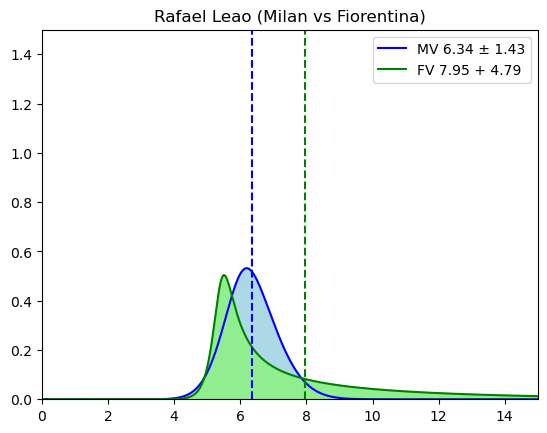

Rafael Leao: MV 6.34 ± 1.43; FV 7.95 + 4.79


[array([6.3442238 , 7.94607029]),
 array([0.71331024, 2.395806  ], dtype=float32),
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>]]

In [34]:
predict_player('Rafael Leao', plot = 1, log = 1)

Code for predicting the probability distribution of total team points

In [30]:
squad = ['Falcone',
        'Valeri',
        'Di Lorenzo',
        'Parisi',
        'Mario Rui',
        'Strefezza',
        'Frattesi',
        'Felipe Anderson',
        'Beto',
        'Abraham',
        'Nzola']


dist = [None] * len(squad)

defenders = list([0]) * len(squad)


for i in range(len(squad)):
    [X, y, dist[i]] = predict_player(squad[i], plot = 0, log = 0)  
    
    if(players['r'][squad[i]] == 'D'):
        defenders[i] = 1

In [31]:
ITERS = 500

MOD = True

total_points = np.zeros(ITERS)
clean_sheets = np.zeros(ITERS)
mod_points = np.zeros(ITERS)

mv_samples = [None] * len(squad)
fv_samples = [None] * len(squad)

for i in range(len(squad)):
    mv_samples[i] = dist[i][0].sample(ITERS)
    fv_samples[i] = dist[i][1].sample(ITERS)
    
cs_samples = dist[0][2].sample(ITERS)

for k in range(ITERS):
    d_points = list([0]) * len(squad)
    
    cleansheet = float(cs_samples[k])
    total_points[k] += cleansheet
    clean_sheets[k] += cleansheet
    
    for i in range(len(squad)):      
        if(defenders[i] == 1):
            d_points[i] = float(mv_samples[i][k])

        total_points[k] += float(fv_samples[i][k])
        
    d_points.sort(reverse = True)

    if(MOD and d_points[3] > 0): # minimum 3 defenders to get MOD
        mod_avg = 0
        for j in range(3):
            mod_avg += round(d_points[j] * 2) / 2
        mod_avg /= 3

        if(mod_avg >= 7):
            mod_points[k] = 6
        elif(mod_avg >= 6.5):
            mod_points[k] = 3
        elif(mod_avg >= 6):
            mod_points[k] = 1

        total_points[k] += mod_points[k]
    
        
print('Avg Total Points = ' + str(total_points.mean()))
print('Avg Mod Points = ' + str(mod_points.mean()))
print('Avg Clean Sheets = ' + str(clean_sheets.mean()))


Avg Total Points = 75.96627577018738
Avg Mod Points = 1.478
Avg Clean Sheets = 0.364


In [32]:
loc_0 = total_points.mean()

squad_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(3),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.SinhArcsinh(loc= loc_0 + t[..., 0], scale = 1e-3 + tf.math.softplus(t[..., 1]), 
                                                    skewness = t[..., 2], tailweight = 0.8) # fixed tailweight seems ok
        )
    ]
)

def negloglik(y, distr):
    return -distr.log_prob(y)

squad_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1), loss=negloglik)

dummy_input = np.zeros(total_points.shape)[:, np.newaxis]
squad_model.fit(dummy_input, total_points, epochs=100, verbose=False)

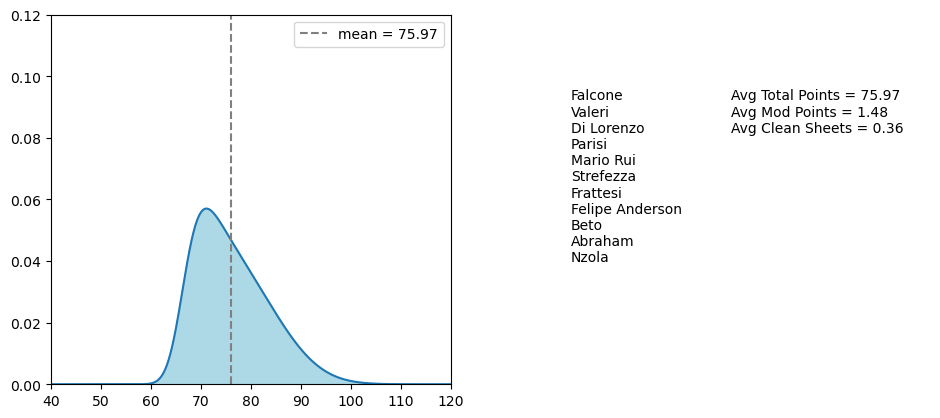

In [33]:
squad_points_dist = squad_model(np.zeros(1)[:, np.newaxis])


x = np.arange(start = 0, stop = 200, step = 0.001)
prb = squad_points_dist.prob(x)

mn = total_points.mean()

f, ax = plt.subplots(1, 2)

ax[0].plot(x, prb)
ax[0].fill_between(x, prb, color = 'lightblue')
ax[0].vlines(x = mn, color = 'grey', ymin = 0, ymax = 3, linestyle = 'dashed', label = 'mean = ' + "{:.2f}".format(mn))

ax[0].set_xlim([40, 120])
ax[0].set_ylim([0, 0.12])

ax[0].legend()

#ax[0].hist(total_points, bins = 20, density = True)


ax[1].text(0.1, 0.8, "\n".join(squad), fontsize=10, transform=ax[1].transAxes, verticalalignment = 'top')

text = "\n".join(['Avg Total Points = ' + "{:.2f}".format(total_points.mean()), 
                  'Avg Mod Points = ' + "{:.2f}".format(mod_points.mean()), 
                  'Avg Clean Sheets = ' + "{:.2f}".format(clean_sheets.mean())])

ax[1].text(0.5, 0.8, text, fontsize=10, transform=ax[1].transAxes, verticalalignment = 'top')

ax[1].axis('off')



plt.subplots_adjust(right=1.5)

plt.show()

Tensorflow seems to have a custom definition for SinhArcsinh distribution. 

Here the code to generate the probability density function is reproduced.

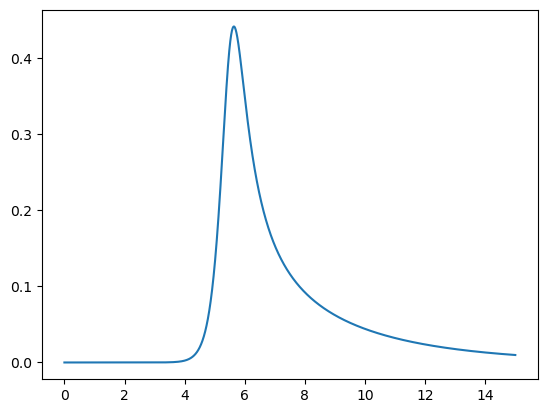

In [110]:
# custom franction to calculate the probability density function

def sinh_archsinh_pdf(x, mu, sigma, eps, delta):

    mul = np.sinh( np.arcsinh(2) * delta)
    
    mul = 2 / mul
    
    sigma_corr = sigma * mul
    
    z = (x - mu) / sigma_corr
    
    
    
    S = np.sinh( -eps + (1/delta) * np.arcsinh(z))
    
    f = np.exp(-0.5 * S * S)

    f /= np.sqrt(2 * np.pi)
    
    f *= 1 / ( sigma_corr * delta )
    
    f *= np.sqrt(1 + S * S)
    
    f /= np.sqrt(1 + z * z)
    
    return f
    

x = np.arange(start = 0, stop = 15, step = 0.001)


plt.plot(x, sinh_archsinh_pdf(x, 5.54, 1.4, 0.8, 1.68))


